# Galactic Lensing of Simulated Cosmic Rays

Deflection in galactic magnetic fields can be accounted for using galactic lenses. To use the lenses efficiently, the ouput of a CRPropa simulation needs first to be filled in probability maps. These maps are then transformed by the lenses according to the rigidity of the particles. From the maps then finally new particles can be generated. 

## Input Results from Extragalactic Simulation

In [1]:
import crpropa
import numpy as np
from projection import *

def CoLat2Lat(latitude):
    return (np.pi/2 - latitude)

def Lat2CoLat(latitude):
    return (np.pi/2 - latitude)

def Convert2Plot(lon):
    lon[(lon > np.pi)] = lon[(lon > np.pi)] - (2.0*np.pi)
    lon[(lon <= np.pi)] = -lon[(lon <= np.pi)]
    return lon

# read data from crpropa output into container. 
# The data is weighted with the source energy ~E**-1
M = crpropa.ParticleMapsContainer()
# crdata = np.genfromtxt("crpropa_output.txt")
# Id = [int(x) for x in crdata[:,0]]
# E = crdata[:,3] * crpropa.EeV
# E0 = crdata[:,4] * crpropa.EeV
# px = crdata[:,11]
# py = crdata[:,12]
# pz = crdata[:,13]
# galactic_longitude = np.arctan2(-1. * py, -1. *px)
# galactic_latitude = np.pi / 2 - np.arccos( -pz / (px*px + py*py+ pz*pz) )

# M.addParticles(Id, E, galactic_longitude, galactic_latitude, E0**-1)


# Alternatively, data can be added manually. 
# This provides freedom to adapt to customized weights used in the simulation
l = (240.16*np.pi/180.0)-2.0*np.pi
b = np.pi/2-(56.69*np.pi/180.0)
meanDir = crpropa.Vector3d()
meanDir.setRThetaPhi(1, b, l)
lons0, lats0 = [], []
for i in xrange(100000):
    particleId = crpropa.nucleusId(1,1)
    energy = 10.0**(np.random.random()*2.0) * crpropa.EeV
    galCenter = crpropa.Vector3d(-1,0,0)
    momentumVector = crpropa.Random.instance().randFisherVector(meanDir, 50)
    M.addParticle(particleId, energy, momentumVector) 
    
    lons0.append(momentumVector.getPhi())
    lats0.append(momentumVector.getTheta())

## Plot Maps

The probability maps for the individual particles can be accessed directly and plotted with healpy. 


In [2]:
%matplotlib inline

import astropy_healpix.healpy as healpy
import matplotlib.pyplot as plt


#stack all maps
crMap = np.zeros(49152)
for pid in M.getParticleIds():
    energies = M.getEnergies(int(pid))
    for i, energy in enumerate(energies):
        crMap += M.getMap(int(pid), energy * crpropa.eV )

#plot maps using healpy
# healpy.mollview(map=crMap, title='Unlensed')
# plt.savefig('unlensed_map.png')


## Apply Galactic Lenses

To apply a lens to a map, a lens object needs to be created and then applied to the map. The normalization of the lens ensures that the lens does not distort the spectra.

In [3]:
%matplotlib inline

# The lens can be downloaded here: https://crpropa.desy.de/ --> Additional downloads
lens_path = "../../JF12regular_Gamale/lens.cfg"
lens = crpropa.MagneticLens(lens_path)
lens.normalizeLens()
M.applyLens(lens)

#stack all maps
crMap = np.zeros(49152)
for pid in M.getParticleIds():
    energies = M.getEnergies(int(pid))
    for i, energy in enumerate(energies):
        crMap += M.getMap(int(pid), energy * crpropa.eV )

#plot maps using healpy
# healpy.mollview(map=crMap, title='Lensed')
# plt.savefig('lensed_map.png')

## Generate Particles from Map

If neeeded, sets of individual particles can then be generated from the maps under preservation of the relative (transformed) input weights. Note that the numbr of particles you can draw from a map depends on the quality of sampling on the input pdf. As a rule of thumb it is most likely not safe to draw more particles from the map than have been used to create the map. 

((199, 199), (199,), (199,))
((199, 199), (199,), (199,))


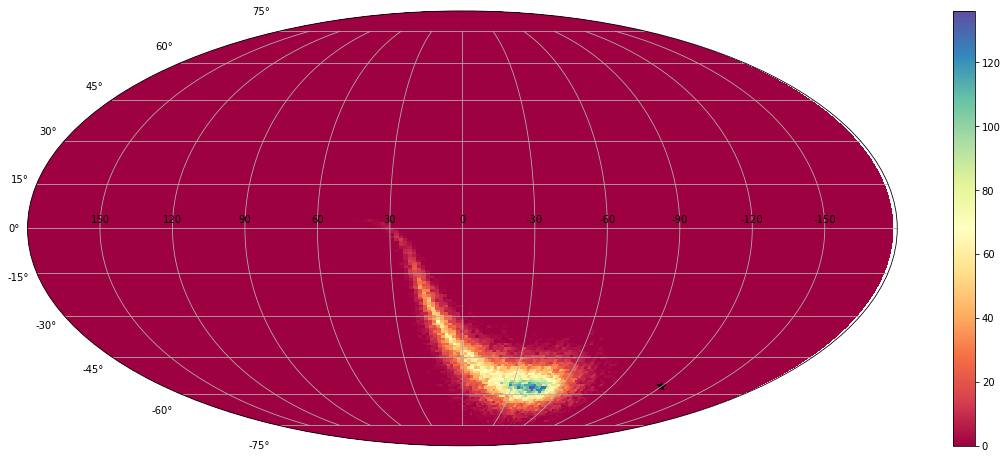

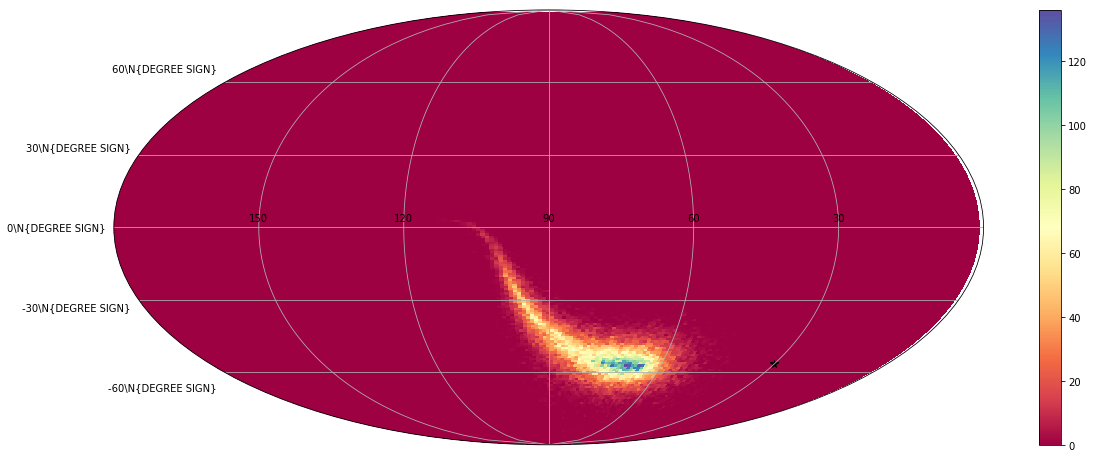

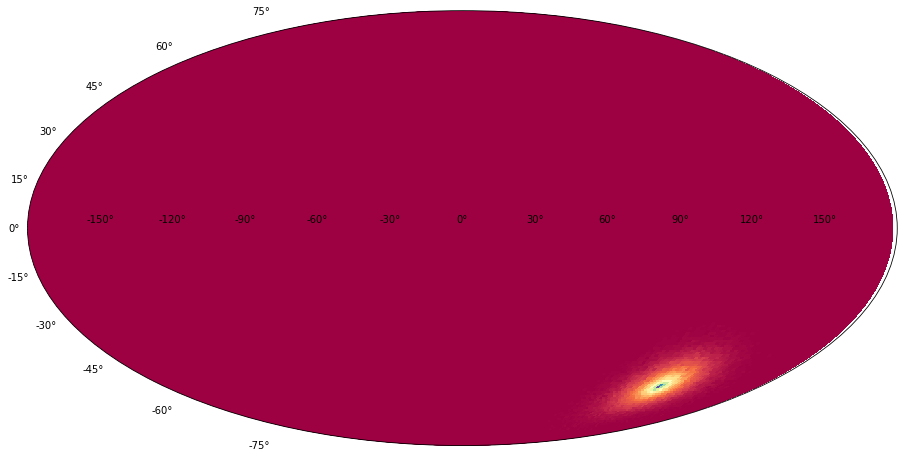

In [4]:
pids, energies, lons, lats = M.getRandomParticles(50000)
lons0 = np.array(lons0)
lats0 = np.array(lats0)

bins = (np.linspace(-np.pi,np.pi,num=200), np.linspace(-np.pi/2,np.pi/2,num=200))
hist, x, y = np.histogram2d(lons, lats, bins = bins)
print (hist.shape, x[:-1].shape, y[:-1].shape)
from scipy.interpolate import interp2d 
interp_func = interp2d(x[:-1],y[:-1], hist.T, kind='cubic')

# create a scatter plot of the particles
plt.figure(figsize=(20,8))
plt.subplot(111, projection='mollweide')

plt.pcolormesh(x[:-1],y[:-1],interp_func(x[:-1],y[:-1]), cmap="Spectral")
#plt.scatter(lons, lats, c=np.log10(energies), lw=0, alpha=1)
plt.colorbar()
plt.gca().set_xticklabels(np.arange(150,-180,-30))
plt.scatter(-l, -np.pi/2+b, c="k", lw=0, alpha=1, marker="*", s=100)
plt.grid()
plt.savefig('scatterd_particles.png')

plt.figure(figsize=(20,8))
plt.subplot(111, projection='custom_auger')

plt.pcolormesh(x[:-1],y[:-1],interp_func(x[:-1],y[:-1]), cmap="Spectral")
#plt.scatter(lons, lats, c=np.log10(energies), lw=0, alpha=1)
plt.colorbar()
plt.gca().set_xticklabels(np.arange(150,-180,-30))
plt.scatter(-l, -np.pi/2+b, c="k", lw=0, alpha=1, marker="*", s=100)
plt.grid()
plt.savefig('scatterd_particles_custom.png')

plt.figure(figsize=(20,8))
plt.subplot(111, projection='mollweide')
hist, x, y = np.histogram2d(-lons0, -np.pi/2+lats0, bins = bins)
print (hist.shape, x[:-1].shape, y[:-1].shape)
from scipy.interpolate import interp2d 
interp_func = interp2d(x[:-1],y[:-1], hist.T, kind='cubic')
plt.pcolormesh(x[:-1],y[:-1],interp_func(x[:-1],y[:-1]), cmap="Spectral")
